In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import os
import cv2

plt.rcParams['axes.linewidth'] = 2
plt.rc("font", size=16, weight="bold", family="Bookman Old Style")
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
pd.read_csv("../data/raw_samples/Ammonia1/serialdata.csv", header=0, index_col=0)

,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8
0,0.355,0.408,0.391,0.490,0.372,0.351,0.345,0.224
1,0.358,0.408,0.389,0.439,0.372,0.372,0.355,0.244
2,0.355,0.407,0.383,0.460,0.379,0.294,0.341,0.235
3,0.344,0.408,0.381,0.433,0.373,0.353,0.345,0.226
4,0.345,0.407,0.397,0.483,0.363,0.326,0.307,0.227
...,...,...,...,...,...,...,...,...
162,0.894,0.540,0.949,1.293,1.076,0.894,1.185,0.527
163,0.885,0.537,0.950,1.291,1.073,0.860,1.182,0.456
164,0.883,0.535,0.942,1.279,1.098,0.797,1.158,0.441
165,0.879,0.533,0.946,1.297,1.083,0.849,1.135,0.432


In [4]:
pd.DataFrame(data={"Channel 1":[0],
                   "Channel 2":[1]})

,Channel 1,Channel 2
0,0,1


# Notation Guide
- MOS - Metal Oxide Sensors
- CSA - Colorometric Sensor Array

In [2]:
class MetalOxideSemiconductorResponse:

    def __init__(self, sample_path=None):
        # Load Resistors (kOhm)
        self.sensors = ["MQ-2",
                        "MQ-3",
                        "MQ-5",
                        "MQ-6",
                        "MQ-8",
                        "MQ-9",
                        "MQ-135",
                        "MQ-138"]
        self.load_resistors = pd.Series(data=[2.5,
                                              0.52,
                                              56,
                                              96.2,
                                              29,
                                              95,
                                              16.9,
                                              95.6],
                                        index=self.sensors).T

        self.raw = pd.read_csv(sample_path,
                               header=0,
                               index_col=0,
                               names=self.sensors)
        self.raw.index.name = "Time(s)"

        self.voltage = 5 - self.raw
        self.current = self.raw/self.load_resistors
        self.conductance = self.current/self.voltage

In [8]:
mos = MetalOxideSemiconductorResponse(sample_path="../data/raw_samples/Acetone1/serialdata.csv");
mos.voltage

,MQ-2,MQ-3,MQ-5,MQ-6,MQ-8,MQ-9,MQ-135,MQ-138
Time(s),,,,,,,,
0,4.699,4.764,4.560,4.625,4.611,4.649,4.714,4.774
1,4.698,4.762,4.580,4.611,4.637,4.676,4.706,4.830
2,4.697,4.761,4.598,4.661,4.674,4.697,4.676,4.786
3,4.695,4.763,4.598,4.605,4.657,4.636,4.665,4.798
4,4.703,4.761,4.637,4.544,4.660,4.644,4.671,4.829
...,...,...,...,...,...,...,...,...
290,4.361,3.681,3.535,2.213,4.172,1.887,4.032,2.377
291,4.367,3.683,3.515,2.221,4.204,1.877,3.998,2.358
292,4.367,3.684,3.529,2.235,4.195,1.910,4.011,2.401


In [3]:
class PaperBasedResponse:

    def __init__(self, sample_directory=None, sample_code=None):
        folder_path = os.path.join(sample_directory, sample_code)
        file_path = os.path.join(folder_path, "images")
        number_of_images = len(os.listdir(file_path))
        file_names = [str(i+1) + ".jpg" for i in range(number_of_images)]
        files = [os.path.join(file_path, name) for name in file_names]
        self.sensor_BGR_images = [cv2.imread(file) for file in files]
        self.sensor_RGB_images = [cv2.cvtColor(img,
                                               cv2.COLOR_BGR2RGB) for img
                                  in self.sensor_BGR_images]

        self.dye_names = ["Reference",
                          "Phenol Red",
                          "Methylene Blue",
                          "Methyl Red"]

        self.centres_of_dye_spots = {
            "Reference": (self.width//4, self.height//4),
            "Phenol Red": (3 * self.width//4, self.height//4),
            "Methylene Blue": (3 * self.width//4, 3 * self.height//4),
            "Methyl Red": (self.width//4, 3 * self.height//4)
        }

        self.dyespots_RGB_images = {
            "Reference": [
                self.__crop_by_centre(
                    img,
                    self.centres_of_dye_spots["Reference"])
                for img in self.sensor_RGB_images],
            "Phenol Red": [
                self.__crop_by_centre(
                    img,
                    self.centres_of_dye_spots["Phenol Red"])
                for img in self.sensor_RGB_images],
            "Methylene Blue": [
                self.__crop_by_centre(
                    img,
                    self.centres_of_dye_spots["Methylene Blue"])
                for img in self.sensor_RGB_images],
            "Methyl Red": [
                self.__crop_by_centre(
                    img,
                    self.centres_of_dye_spots["Methyl Red"])
                for img in self.sensor_RGB_images]
        }

        self.dyespots_HSV_images = {
            "Reference": [cv2.cvtColor(
                img,
                cv2.COLOR_RGB2HSV_FULL)
                for img in self.dyespots_RGB_images["Reference"]],
            "Phenol Red": [cv2.cvtColor(
                img,
                cv2.COLOR_RGB2HSV_FULL)
                for img in self.dyespots_RGB_images["Phenol Red"]],
            "Methylene Blue": [cv2.cvtColor(
                img,
                cv2.COLOR_RGB2HSV_FULL)
                for img in self.dyespots_RGB_images["Methylene Blue"]],
            "Methyl Red": [cv2.cvtColor(
                img,
                cv2.COLOR_RGB2HSV_FULL)
                for img in self.dyespots_RGB_images["Methyl Red"]],
        }

    def color_values(self, rep="Red"):
        if rep == "Red" or rep == "Hue":
            index = 0
        elif rep == "Green" or rep == "Saturation":
            index = 1
        else:
            index = 2
        if rep in ["Red", "Green", "Blue"]:
            data = {
                "Reference": [
                    cv2.mean(img)[index]
                    for img in self.dyespots_RGB_images["Reference"]],
                "Phenol Red": [
                    cv2.mean(img)[index]
                    for img in self.dyespots_RGB_images["Phenol Red"]],
                "Methylene Blue": [
                    cv2.mean(img)[index]
                    for img in self.dyespots_RGB_images["Methylene Blue"]],
                "Methyl Red": [
                    cv2.mean(img)[index]
                    for img in self.dyespots_RGB_images["Methyl Red"]]
            }
        else:
            data = {
                "Reference": [
                    cv2.mean(img)[index]
                    for img in self.dyespots_HSV_images["Reference"]],
                "Phenol Red": [
                    cv2.mean(img)[index]
                    for img in self.dyespots_HSV_images["Phenol Red"]],
                "Methylene Blue": [
                    cv2.mean(img)[index]
                    for img in self.dyespots_HSV_images["Methylene Blue"]],
                "Methyl Red": [
                    cv2.mean(img)[index]
                    for img in self.dyespots_HSV_images["Methyl Red"]]
            }
        return pd.DataFrame.from_dict(data)

    def __getitem__(self, index=0):
        return self.sensor_RGB_images[index]

    @property
    def shape(self):
        return self.sensor_RGB_images[0].shape

    @property
    def height(self):
        return self.shape[0]

    @property
    def width(self):
        return self.shape[1]

    def __crop_by_centre(self, img=None,
                         centre=(50, 50), frame_size=100):
        return img[centre[1]-frame_size//2: centre[1] + frame_size//2,
                   centre[0]-frame_size//2: centre[0]+frame_size//2]

In [4]:
def get_typical_sample_by_average_MOS(path=None, gas_name=None, number_of_samples=None):
    sensor_names = ["MQ-2", "MQ-3", "MQ-5",
                    "MQ-6", "MQ-8", "MQ-9", "MQ-135", "MQ-138"]
    load_resistors = pd.Series(data=[2.5,
                                     0.52,
                                     56,
                                     96.2,
                                     29,
                                     95,
                                     16.9,
                                     95.6],
                               index=sensor_names).T
    sample_paths = [os.path.join(
        path,
        gas_name + str(n) + "\\" + "serialdata.csv")
        for n in range(1, number_of_samples+1)]
    samples = [
        MetalOxideSemiconductorResponse(path).conductance.iloc[:167]
        for path in sample_paths]
    return sum(samples)/len(samples)

In [5]:
def average_conductance_of_MOS_sensor():
    ammonia = read_samples(
        path="datasets", gas_name="Ammonia", number_of_samples=12)
    acetone = read_samples(
        path="datasets", gas_name="Acetone", number_of_samples=12)
    benzene = read_samples(
        path="datasets", gas_name="Benzene", number_of_samples=12)
    ethanol = read_samples(
        path="datasets", gas_name="Ethanol", number_of_samples=12)
    methanol = read_samples(
        path="datasets", gas_name="Methanol", number_of_samples=12)
    toluene = read_samples(
        path="datasets", gas_name="Toluene", number_of_samples=12)
    samples = [ammonia, acetone,
               benzene, ethanol, methanol, toluene]
    gases = ["Ammonia", "Acetone", "Benzene",
             "Ethanol", "Methanol", "Toluene"]
    figure, axs = plt.subplots(
        nrows=2, ncols=3,
        figsize=(15, 8),
        dpi=300, sharex=True,
        sharey=True)
    for ax, sample, gas in zip(axs.flat, samples, gases):
        sample.plot(ax=ax, linewidth=3)
        ax.set_title(gas, fontsize=18, fontweight="bold")
        ax.grid(which="major", linestyle="--",
                color="black", alpha=0.4)
        ax.legend(loc="upper center", ncol=4, fontsize=9)
        ax.set_ylim([0, 40])
        ax.set_ylabel("Sensor Conductance (mS)",
                      fontsize=15, fontweight="bold")
        ax.set_xlabel("Time (s)", fontsize=15, fontweight="bold")
    figure.suptitle(
        "Average Conductance Responses of Metal Oxide Sensors (N=12)",
        fontsize=20, fontweight="bold")
    figure.tight_layout()

In [10]:
test_gas = "Ammonia"
typical_sample = get_typical_sample_by_average_MOS(
    path="../data/raw_samples", 
    gas_name=test_gas,
    number_of_samples=4)

NameError: name 'gas' is not defined

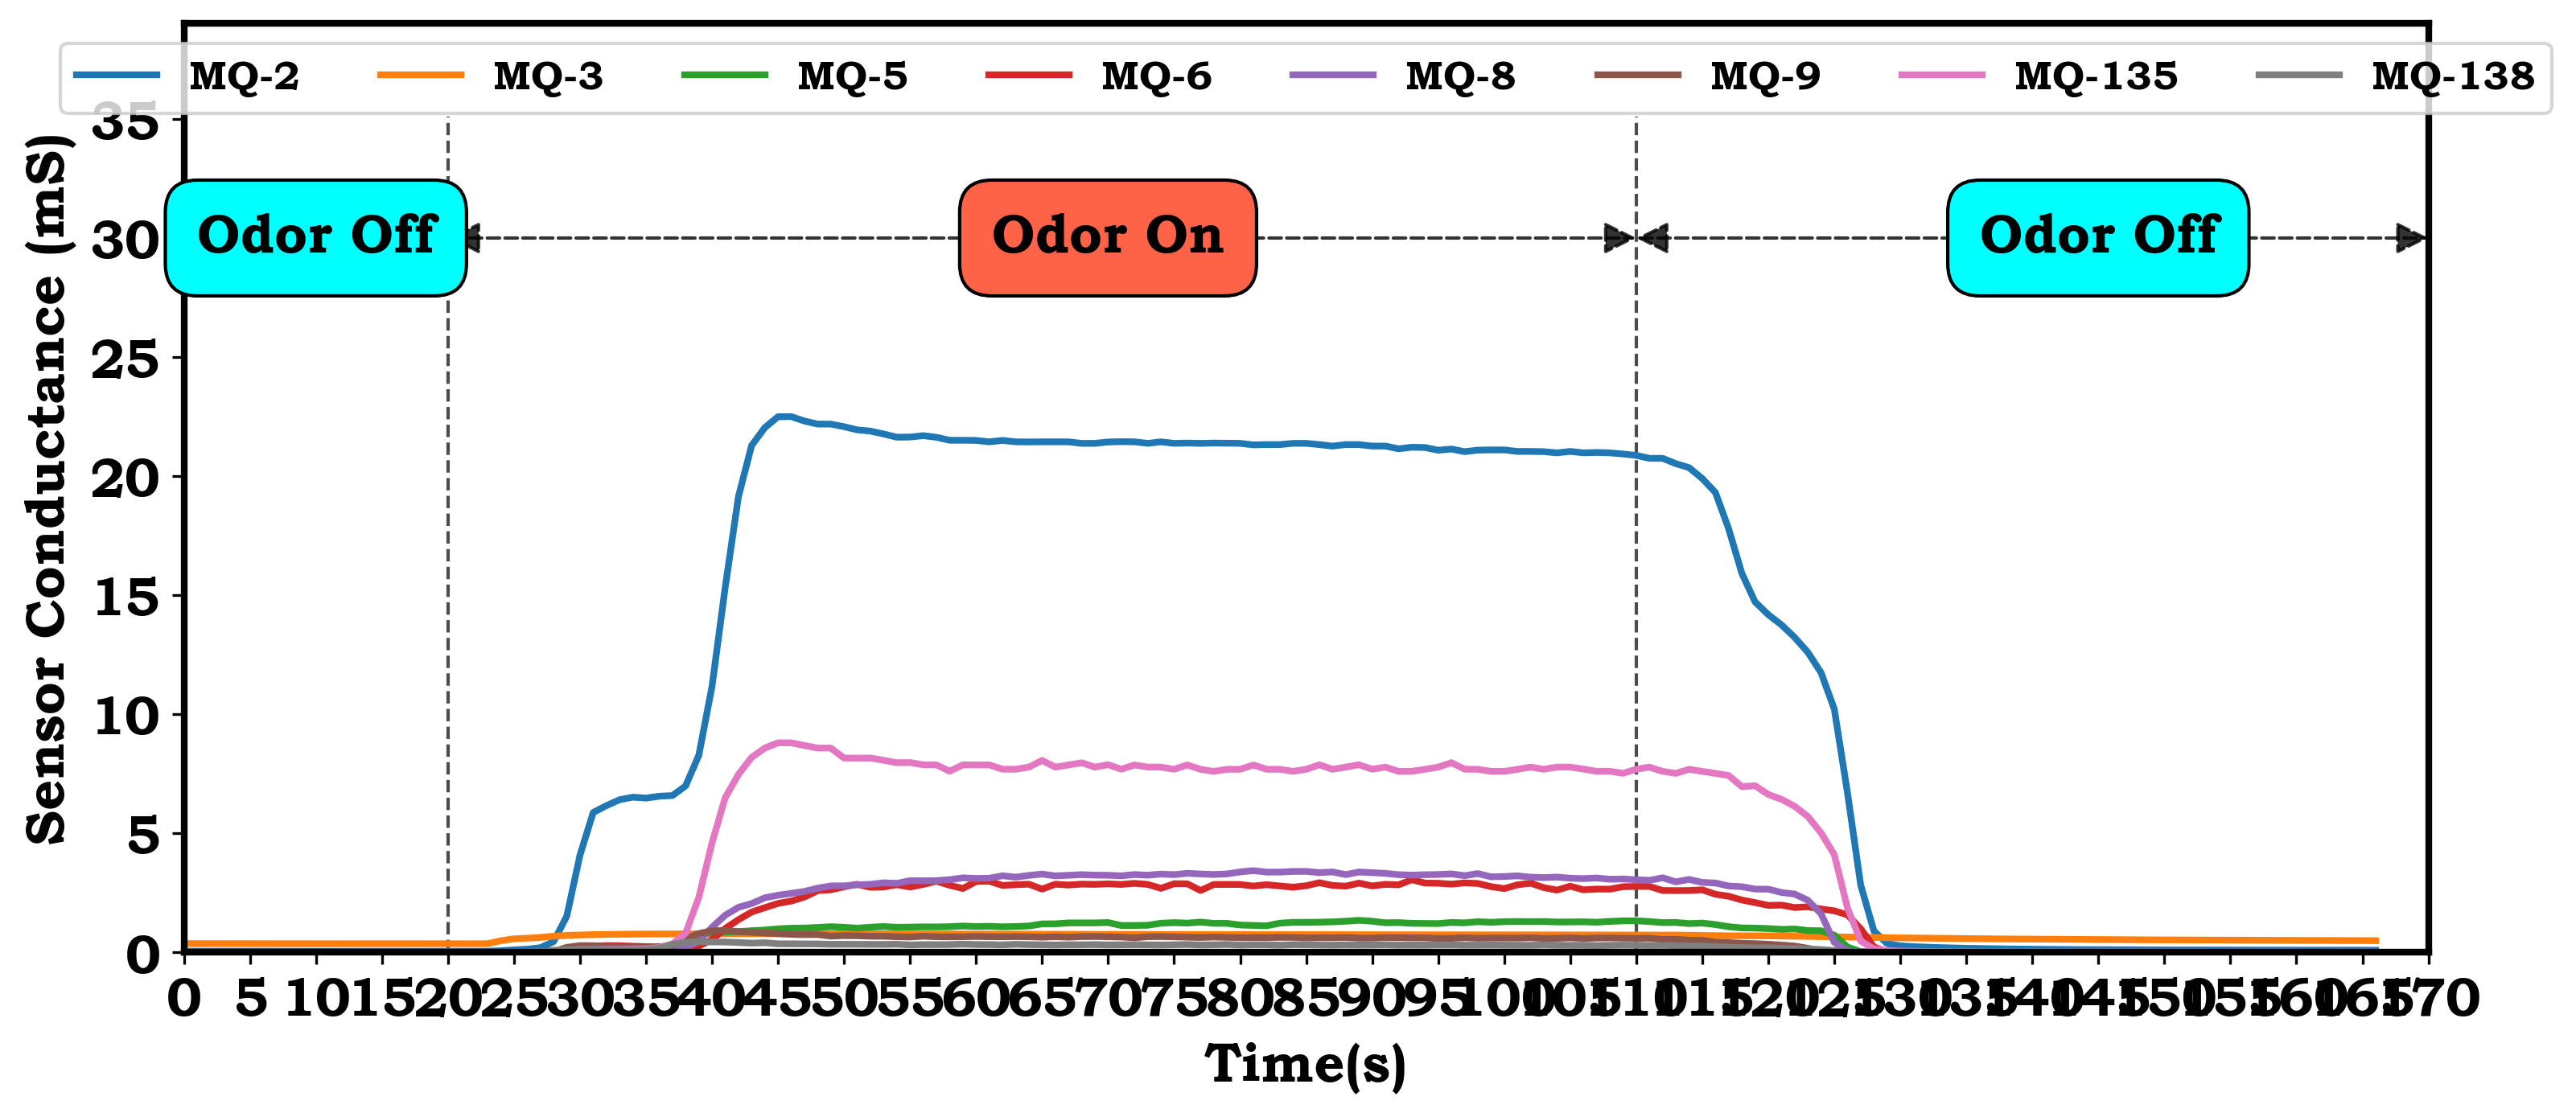

In [11]:
figure, ax = plt.subplots(
    nrows=1, ncols=1,
    figsize=(12, 5), dpi=300)
ax.set_xticks(list(range(0, 180, 5)))
ax.set_xticklabels(list(range(0, 180, 5)), rotation=90)
ax.set_xlabel("Time (s)", fontsize=16, fontweight="bold")
ax.set_ylabel(
    "Sensor Conductance (mS)",
    fontsize=16, fontweight="bold")
# ax.grid(which="major", color="black", linestyle="--", alpha=0.8)
ax.axvline(x=20, ymin=0, ymax=0.9, linewidth=1,
           linestyle="--", color="black", alpha=0.7)
ax.axvline(x=110, ymin=0, ymax=0.9, linewidth=1,
           linestyle="--", color="black", alpha=0.7)

typical_sample.plot(ax=ax, linewidth=2, kind="line")

baseline_arrow = FancyArrowPatch(
    posA=(0, 30), posB=(20, 30),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
adsorption_arrow = FancyArrowPatch(
    posA=(20, 30), posB=(110, 30),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
desorption_arrow = FancyArrowPatch(
    posA=(110, 30), posB=(170, 30),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
ax.add_artist(baseline_arrow)
ax.annotate("Odor Off", xy=(10, 30), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="aqua"))
ax.annotate("Odor On", xy=(70, 30), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="tomato"))
ax.annotate("Odor Off", xy=(145, 30), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="aqua"))
ax.add_artist(adsorption_arrow)
ax.add_artist(desorption_arrow)
ax.set_xlim([0, 170])
ax.set_ylim([0, 39])
ax.legend(loc="upper center", ncol=8, fontsize=12)
ax.set_title(
    "Typical Metal Oxide Gas Sensor Responses in The Presence of " + gas,
    fontsize=20, fontweight="bold")
figure.tight_layout()

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), dpi=300)
typical_paperbased = PaperBasedResponse("raw_samples", "Ammonia10")
df = typical_paperbased.color_values(rep="Hue")
df.index = df.index * 10
df.plot(ax=ax, kind="line", marker="o")
ax.axvline(x=20, ymin=0, ymax=0.9, linewidth=1,
           linestyle="--", color="black", alpha=0.7)
ax.axvline(x=110, ymin=0, ymax=0.9, linewidth=1,
           linestyle="--", color="black", alpha=0.7)
baseline_arrow = FancyArrowPatch(
    posA=(0, 268), posB=(20, 268),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
adsorption_arrow = FancyArrowPatch(
    posA=(20, 268), posB=(110, 268),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
desorption_arrow = FancyArrowPatch(
    posA=(110, 268), posB=(170, 268),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
ax.add_artist(baseline_arrow)
ax.annotate("Odor Off", xy=(10, 270), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="aqua"))
ax.annotate("Odor On", xy=(70, 270), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="tomato"))
ax.annotate("Odor Off", xy=(145, 270), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="aqua"))
ax.add_artist(adsorption_arrow)
ax.add_artist(desorption_arrow)
ax.set_xticks(list(range(0, 180, 10)))
ax.set_xticklabels(list(range(0, 180, 10)), rotation=90)
ax.set_xlabel("Time (s)", fontsize=15, fontweight="bold")
ax.set_ylabel("Mean Hue", fontsize=15, fontweight="bold")
ax.set_xlim([0, 170])
ax.set_ylim([0, 400])
ax.legend(loc="upper center", ncol=4, fontsize=16)
ax.set_title(
    "Typical Colorimetric Sensor Responses in The Presence of Ammonia",
    fontsize=20, fontweight="bold")
figure.tight_layout()

In [ ]:
figure, axs = plt.subplots(nrows=4, ncols=17,
                           figsize=(12, 5),
                           dpi=300, sharex=True)
for c in range(17):
    for r, dye in zip(list(range(4)), ["Reference", "Phenol Red",
                                       "Methyl Red", "Methylene Blue"]):
        if dye == "Reference":
            axs[r, c].set_title(str(c*10) + " s",
                                fontweight="bold")
        axs[r, c].imshow(typical_paperbased.dyespots_RGB_images[dye][c])
        axs[r, c].axis("off")
figure.suptitle(
    """A typical colorimetric sensor reponse 
            in the presence of ammonia test gas""",
    fontsize=20, fontweight="bold")
figure.tight_layout()

In [ ]:
code = 6
color_rep = "Hue"
responses = [PaperBasedResponse("raw_samples", name + str(code)) for name in
             ["acetone", "ammonia", "benzene",
             "methanol", "ethanol", "toluene"]]
figure, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6),
                           dpi=300, sharex=True, sharey=True)
legend = None
for ax, r, title in zip(axs.flat, responses, [
    "Acetone", "Ammonia", "Benzene",
        "Methanol", "Ethanol", "Toluene"]):
    df = r.color_values(color_rep)
    df.index = df.index * 10
    df.iloc[:17].plot(kind="line",
                      ax=ax)
    ax.set_title(title, fontweight="bold", fontsize=16)
    ax.set_xlabel("Time (seconds)", fontweight="bold", fontsize=14)
    ax.set_ylabel("Average " + color_rep, fontweight="bold", fontsize=14)
    ax.set_xticks(df.index)
    ax.set_xticklabels(df.index, rotation=90)
    ax.grid(which="major", color="black", linestyle="--", alpha=0.4)
    ax.set_xlim([0, 160])
    ax.set_ylim([0, 300])
    ax.legend(loc="upper center", ncol=2, fontsize=9)
    legend = ax.get_legend_handles_labels()
figure.tight_layout()

In [14]:
ethanol_respones = [PaperBasedResponse("../data/raw_samples/", "Ethanol" + str(code))
                    for code in range(1, 13)]

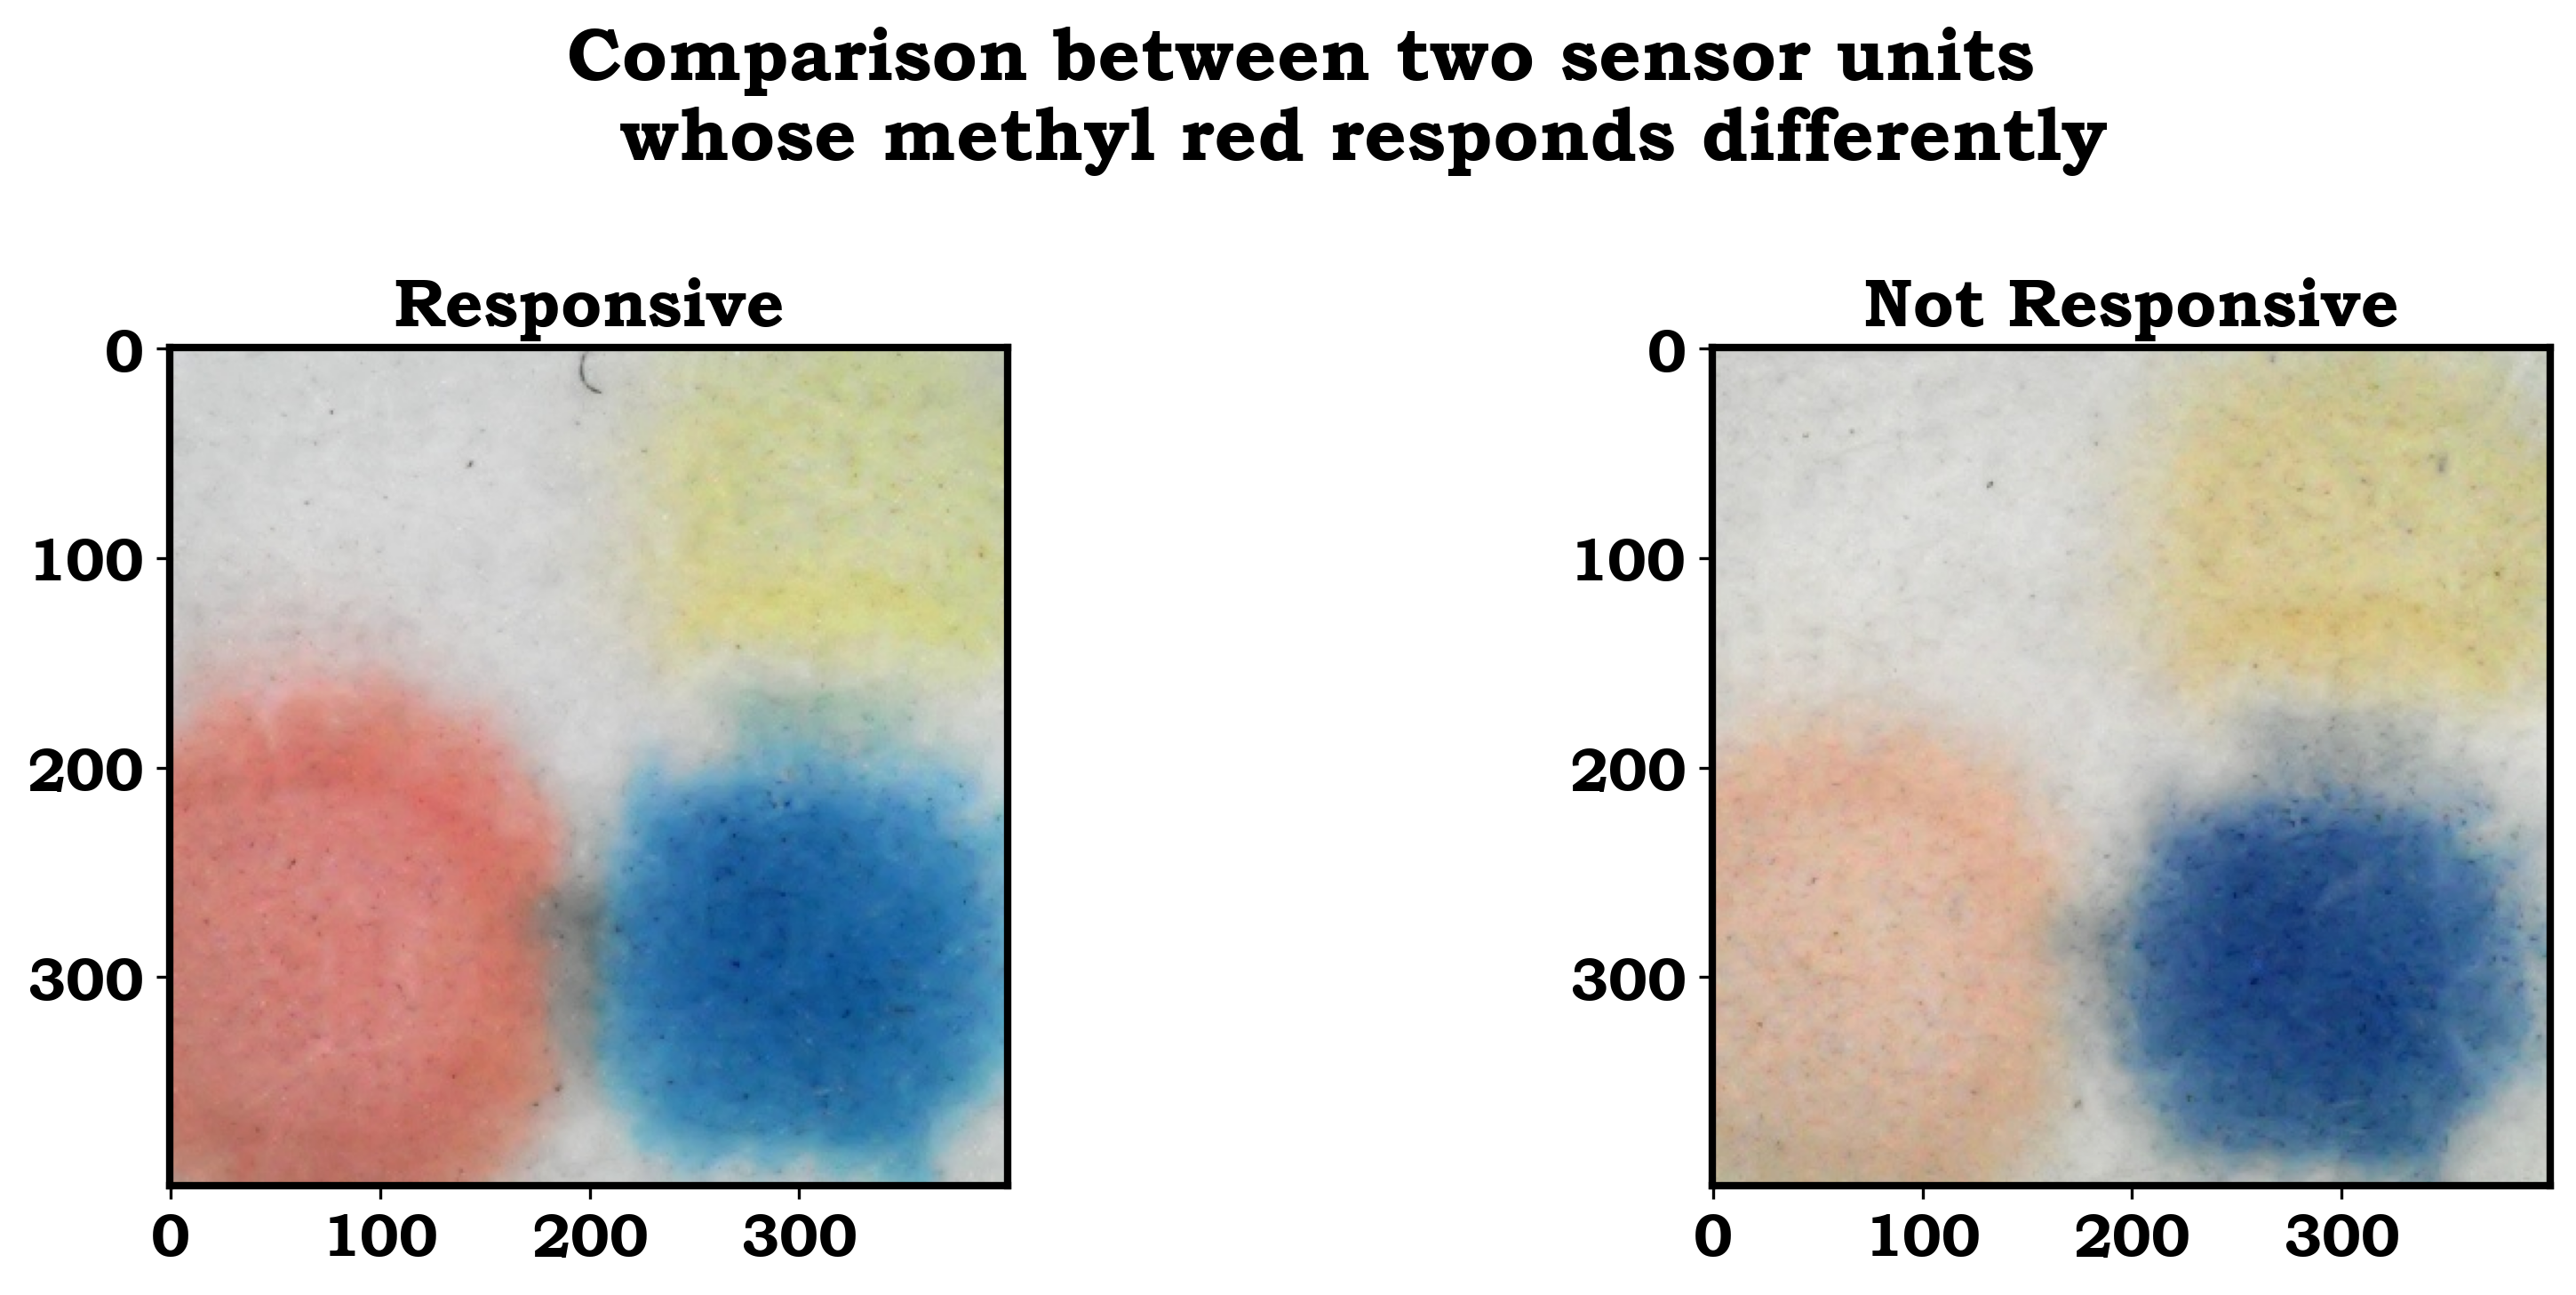

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=300)
for ax, response, title in zip(axs,
                               [ethanol_respones[0],
                                ethanol_respones[8]],
                               ["Responsive", "Not Responsive"]):
    ax.imshow(response[0])
    ax.set_title(title, fontsize=18, fontweight="bold")
fig.suptitle(
    """Comparison between two sensor units 
    whose methyl red responds differently""",
    fontsize=20, fontweight="bold")
fig.tight_layout()

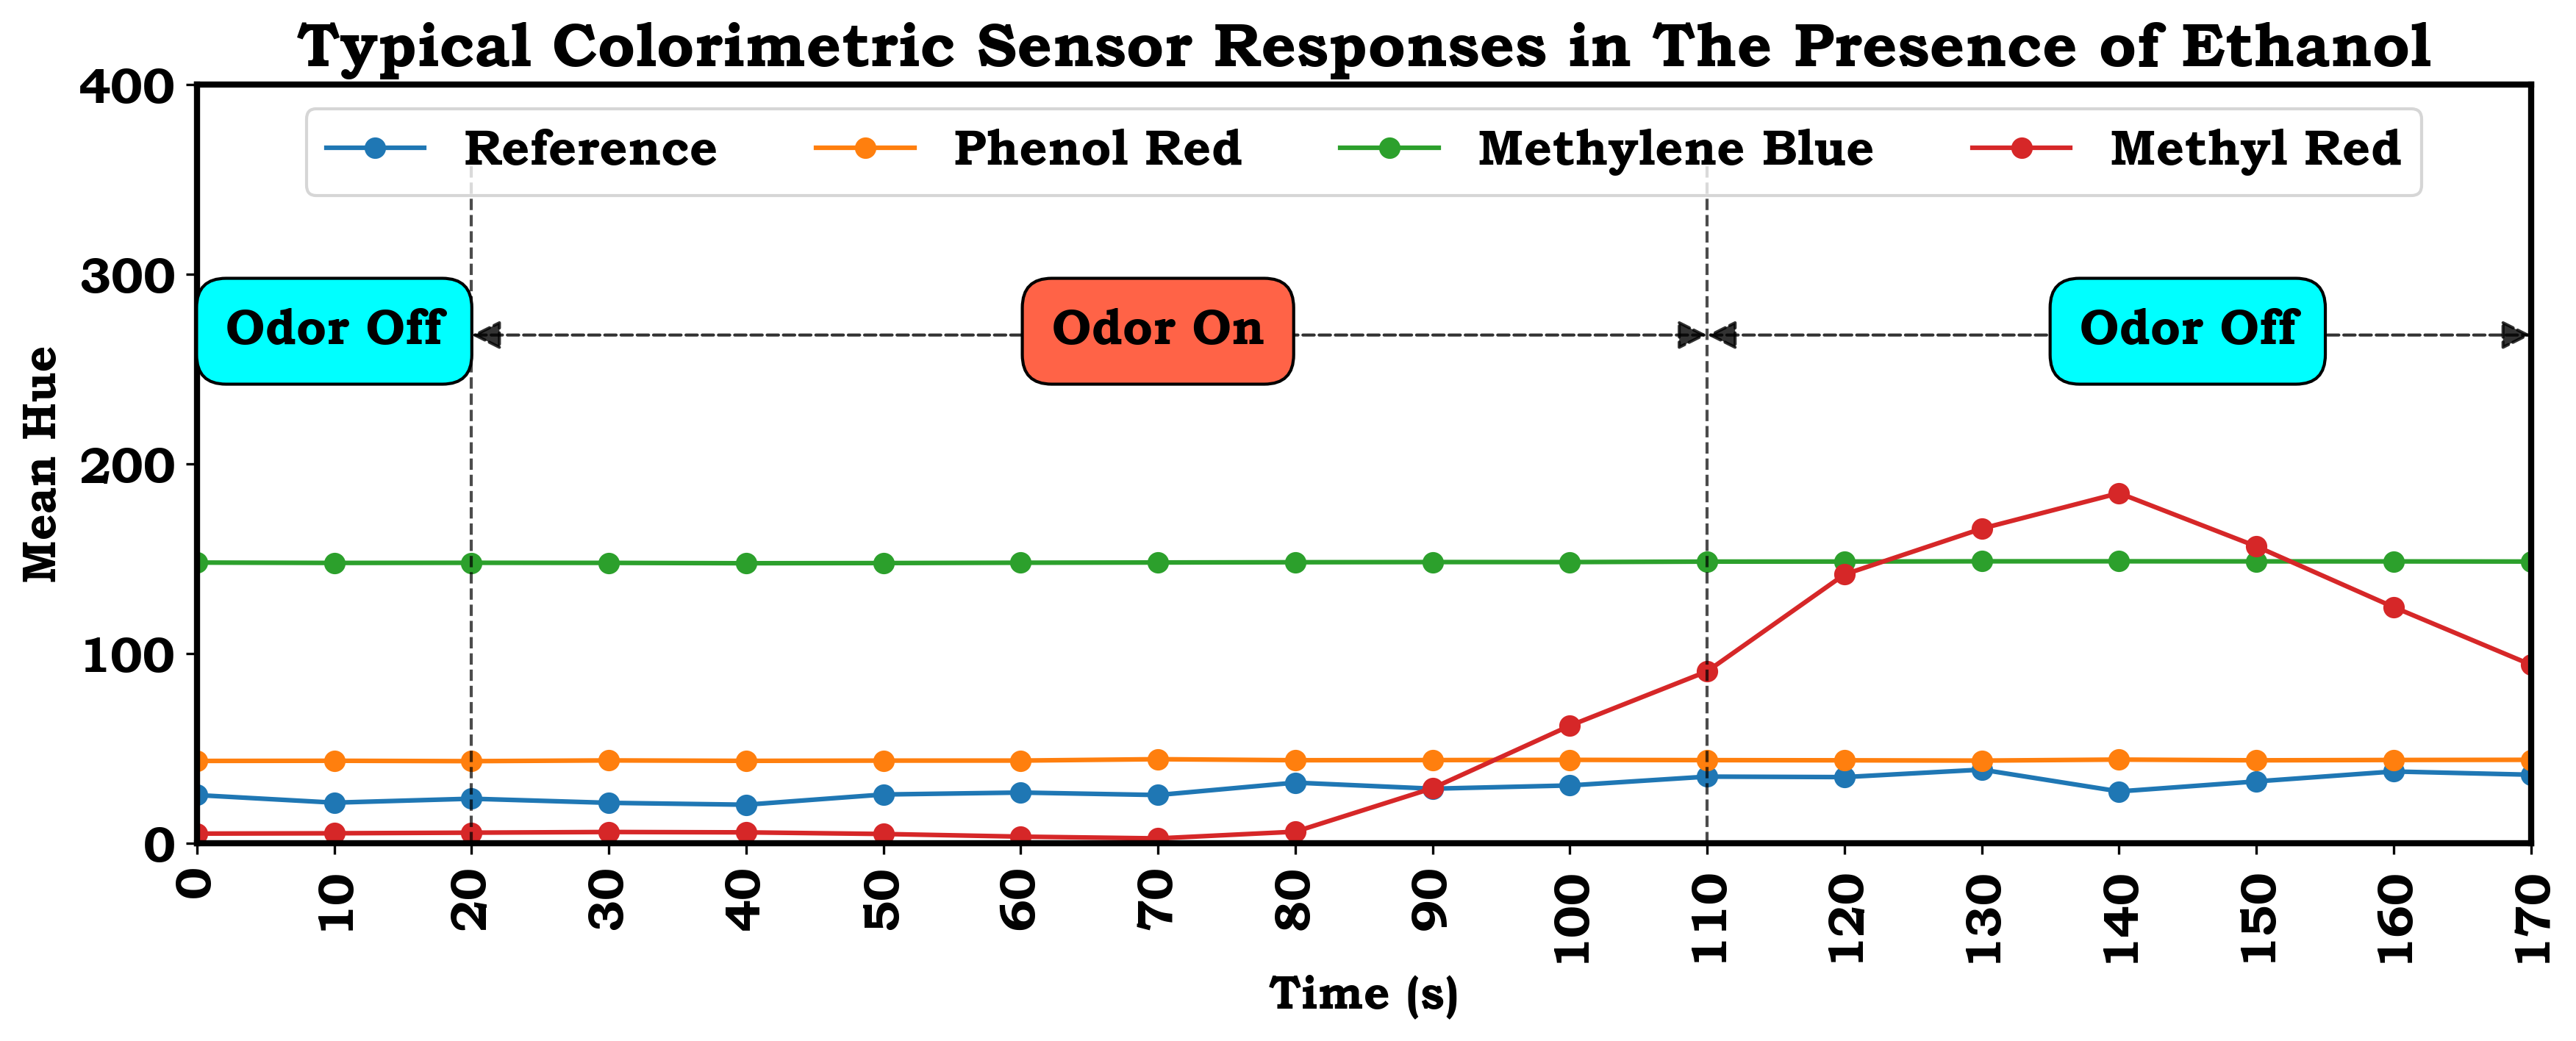

In [17]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), dpi=300)
typical_paperbased = PaperBasedResponse("../data/raw_samples", "Ethanol2")
df = typical_paperbased.color_values(rep="Hue")
df.index = df.index * 10
df.plot(ax=ax, kind="line", marker="o")
ax.axvline(x=20, ymin=0, ymax=0.9, linewidth=1,
           linestyle="--", color="black", alpha=0.7)
ax.axvline(x=110, ymin=0, ymax=0.9, linewidth=1,
           linestyle="--", color="black", alpha=0.7)
baseline_arrow = FancyArrowPatch(
    posA=(0, 268), posB=(20, 268),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
adsorption_arrow = FancyArrowPatch(
    posA=(20, 268), posB=(110, 268),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
desorption_arrow = FancyArrowPatch(
    posA=(110, 268), posB=(170, 268),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
ax.add_artist(baseline_arrow)
ax.annotate("Odor Off", xy=(10, 270), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="aqua"))
ax.annotate("Odor On", xy=(70, 270), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="tomato"))
ax.annotate("Odor Off", xy=(145, 270), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="aqua"))
ax.add_artist(adsorption_arrow)
ax.add_artist(desorption_arrow)
ax.set_xticks(list(range(0, 180, 10)))
ax.set_xticklabels(list(range(0, 180, 10)), rotation=90)
ax.set_xlabel("Time (s)", fontsize=15, fontweight="bold")
ax.set_ylabel("Mean Hue", fontsize=15, fontweight="bold")
ax.set_xlim([0, 170])
ax.set_ylim([0, 400])
ax.legend(loc="upper center", ncol=4, fontsize=16)
ax.set_title(
    "Typical Colorimetric Sensor Responses in The Presence of Ethanol",
    fontsize=20, fontweight="bold")
figure.tight_layout()

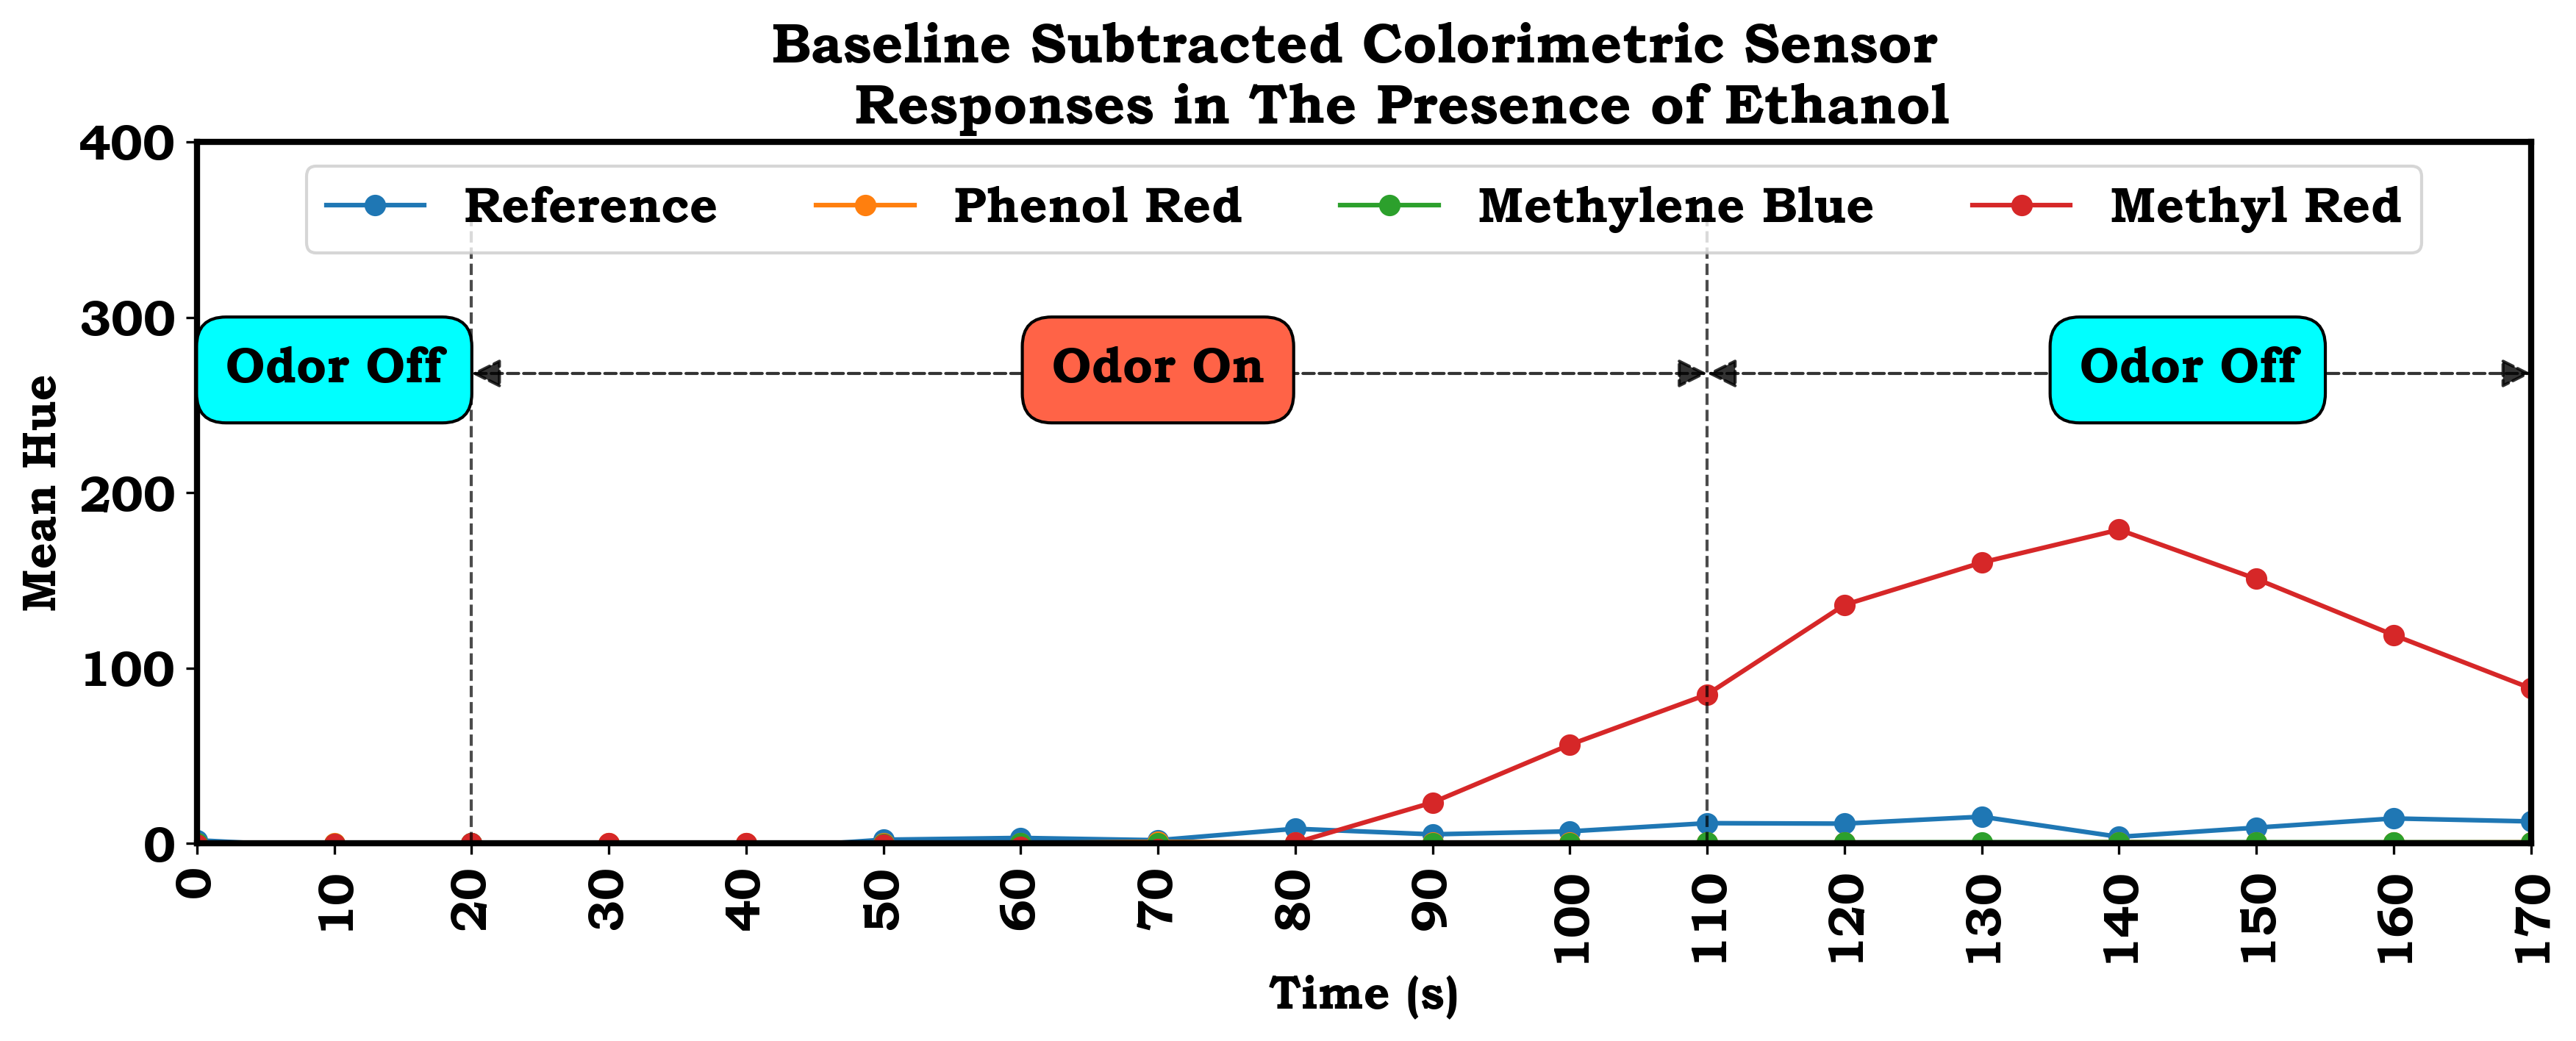

In [19]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), dpi=300)
typical_paperbased = PaperBasedResponse("../data/raw_samples", "Ethanol2")
df = typical_paperbased.color_values(
    rep="Hue") - typical_paperbased.color_values(rep="Hue").iloc[2]
df.index = df.index * 10
df.plot(ax=ax, kind="line", marker="o")
ax.axvline(x=20, ymin=0, ymax=0.9, linewidth=1,
           linestyle="--", color="black", alpha=0.7)
ax.axvline(x=110, ymin=0, ymax=0.9, linewidth=1,
           linestyle="--", color="black", alpha=0.7)
baseline_arrow = FancyArrowPatch(
    posA=(0, 268), posB=(20, 268),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
adsorption_arrow = FancyArrowPatch(
    posA=(20, 268), posB=(110, 268),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
desorption_arrow = FancyArrowPatch(
    posA=(110, 268), posB=(170, 268),
    arrowstyle='<|-|>', color='black',
    mutation_scale=20, shrinkA=0,
    shrinkB=0, alpha=0.8, linestyle="--")
ax.add_artist(baseline_arrow)
ax.annotate("Odor Off", xy=(10, 270), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="aqua"))
ax.annotate("Odor On", xy=(70, 270), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="tomato"))
ax.annotate("Odor Off", xy=(145, 270), xycoords="data",
            va="center", ha="center",
            bbox=dict(boxstyle="round, pad=0.6", fc="aqua"))
ax.add_artist(adsorption_arrow)
ax.add_artist(desorption_arrow)
ax.set_xticks(list(range(0, 180, 10)))
ax.set_xticklabels(list(range(0, 180, 10)), rotation=90)
ax.set_xlabel("Time (s)", fontsize=15, fontweight="bold")
ax.set_ylabel("Mean Hue", fontsize=15, fontweight="bold")
ax.set_xlim([0, 170])
ax.set_ylim([0, 400])
ax.legend(loc="upper center", ncol=4, fontsize=16)
ax.set_title(
    """Baseline Subtracted Colorimetric Sensor 
    Responses in The Presence of Ethanol""",
    fontsize=18, fontweight="bold")
figure.tight_layout()